In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from generate_sin import SampleGenerator

## Experiment 3.1

Пробуем cos нелинейность в lstm, добавляем корреляцию Спирмена в loss-функции

Цель: запустить и проверить, что дает корреляция Спирмена.

Функция потерь: l2-loss + (1 - корреляция Спирмена)

In [2]:
x_left = 0
x_right = 2 * np.pi
param_bounds=[[0.1, 1.9],[0., 2.],[0.1, 1.9],[0., 2.]]
sample_size=100
batch_size=50
set_size=300000
test_percent=0.05
train_size = int(set_size * (1 - test_percent))
cv_fold=10
params_shape=4

(285000, 100, 4) (285000, 100) (15000, 100, 4) (15000, 100)


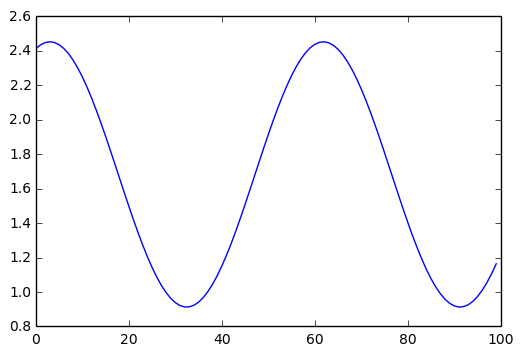

In [3]:
gen = SampleGenerator(x_left, x_right, param_bounds)
X_train, Y_train, X_test, Y_test = gen(sample_size, set_size, test_percent, 'simple_rnn')
plt.plot(Y_train[0])
print X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

In [4]:
data = tf.placeholder(tf.float32, [batch_size, sample_size, params_shape])
target = tf.placeholder(tf.float32, [batch_size, sample_size])

In [5]:
cell = tf.contrib.rnn.BasicLSTMCell(sample_size, state_is_tuple=True, activation=tf.cos)
val, state = tf.nn.dynamic_rnn(cell, data, dtype=tf.float32)
val = tf.transpose(val, [1, 0, 2])
last = tf.gather(val, int(val.get_shape()[0]) - 1)
weight = tf.Variable(tf.truncated_normal([sample_size, int(target.get_shape()[1])]))
bias = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))
prediction = tf.matmul(last, weight) + bias
print prediction.shape

(50, 100)


In [31]:
import scipy.stats

def spearman(x, y):
    rho = []
    for i in range(len(x)):
        r, _ = scipy.stats.spearmanr(x[i], y[i])
        rho.append(1 - r)
    return np.array(rho).astype(np.float32)

loss_l2 = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(prediction, target)), axis=1))
loss_spearman = tf.py_func(spearman, [prediction, target], [tf.float32])

loss = tf.reduce_mean(loss_l2 + loss_spearman)

print loss.shape

<unknown>


In [32]:
#optimizer = tf.train.AdamOptimizer()
optimizer = tf.train.AdagradOptimizer(0.01)
minimize = optimizer.minimize(loss)

In [33]:
def plot_test(i=0):
    ptr = 0
    inp, out = X_test[ptr:ptr+batch_size], Y_test[ptr:ptr+batch_size]
    ptr+=batch_size
    p, l = sess.run([prediction, loss],{data: inp, target: out})
    print l
    plt.plot(Y_test[i])
    plt.plot(p[i])

def plot_train(i=0):
    ptr = 0
    inp, out = X_train[ptr:ptr+batch_size], Y_train[ptr:ptr+batch_size]
    ptr+=batch_size
    p, l = sess.run([prediction, loss],{data: inp, target: out})
    print l
    plt.plot(Y_train[i])
    plt.plot(p[i])

In [34]:
init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

22.8856


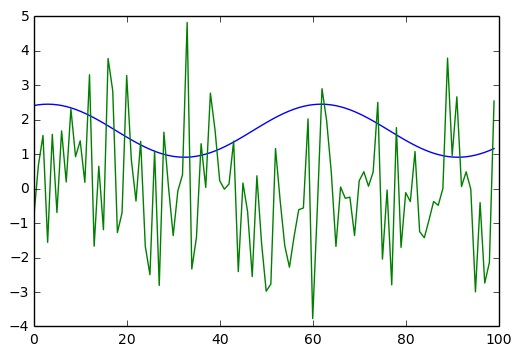

In [35]:
plot_train()

In [36]:
ptr = 0
loss_mass = []
for j in range(train_size // batch_size):
    inp, out = X_train[ptr:ptr+batch_size], Y_train[ptr:ptr+batch_size]
    ptr+=batch_size
    _, l = sess.run([minimize, loss],{data: inp, target: out})
    loss_mass.append(l)

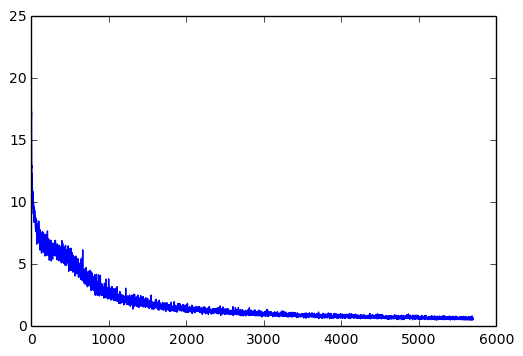

In [37]:
plt.plot(loss_mass)

0.734817


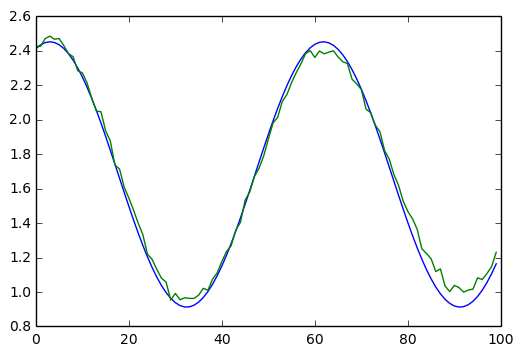

In [38]:
plot_train()

0.650689


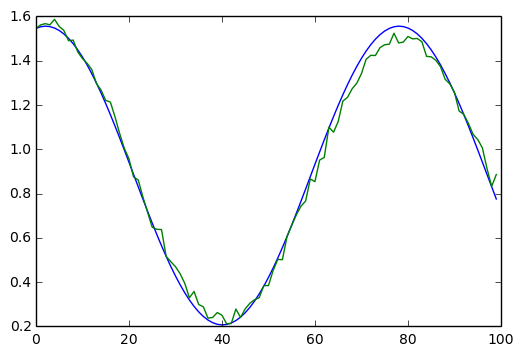

In [39]:
plot_test()

Выводы:

    -недообучена
    -выглядит лучше, чем без спирмена
    -
    